<a href="https://colab.research.google.com/github/c-roets/delayNN/blob/main/DelayNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math
import os
import tensorflow as tf

from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from zipfile import ZipFile

In [101]:
file_name = "delay_dataset.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print("extractie data klaar")

extractie data klaar


In [102]:
# constants
pi = math.pi
train_set = 'stud_train'
i = 0
nummer = 1
evencheck = 0
x = np.arange(0, 1024)
k = 0

In [103]:
def laadarraymetfilenamenuitmap(map):
    j = 0
    filenames = [None] * 600  # array met alle filenames van in folder
    # iterate over files in that directory
    for filename in os.listdir(train_set):
        f = os.path.join(train_set, filename)
        # checking if it is a file
        if os.path.isfile(f):
            # print(f)
            filenames[j] = f
            j += 1
    # print(j)
    # print(filenames)
    filenames.sort()
    # print(filenames)
    return filenames

In [104]:
def plotsignaal(signaal): #signaal is naam bestand tussen aanhalingstekens
    if evencheck % 2 == 0:
        kleur = "red"
    else:
        kleur = "blue"
    plot = plt.figure(nummer)
    plt.xlabel("X axis")
    plt.ylabel("Y axis")
    plt.plot(x,np.load(signaal), color=kleur)

In [105]:
def geefpositiepiek(signaal):
  truncatedsignaal = (signaal.split("P_",1)[1]) #alles voor de xxx wegdoen dus BV ASDR_P_ wegdoen
  piek = ''.join(x for x in truncatedsignaal[0:3] if x.isdigit()) 
  return piek


In [106]:
def voegsamen(signaal1, signaal2):
  return np.concatenate([np.load(signaal1), np.load(signaal2)])

[ 0.0058525  -0.01986469 -0.04207491 ... -0.0574152  -0.00829762
 -0.00452807]
[ 0.05671491  0.13233862  0.13553909 ... -0.14055404  0.04652384
 -0.0200293 ]
[ 0.02777272  0.00563889 -0.00263572 ...  0.01737589 -0.04655543
  0.10096925]
[-0.02646562  0.00862134 -0.16133984 ...  0.00981166 -0.09146151
  0.08931512]
[ 0.01377208 -0.00858241 -0.07961144 ... -0.03874529  0.03172972
 -0.00480592]
[ 0.002289    0.0030389  -0.00606559 ... -0.01395923 -0.00331364
 -0.00661036]
[ 0.00745316  0.01134304 -0.00915406 ...  0.00905909  0.00325763
  0.02669609]
[ 0.00840539 -0.01364817 -0.05678307 ... -0.00490856  0.08418648
 -0.09408574]
[ 0.01119228  0.0192704   0.03397192 ... -0.02166821  0.05640301
 -0.03259998]
[ 0.05900488 -0.05023428 -0.05899971 ...  0.00544719  0.07357725
  0.00610353]
[ 0.00560146 -0.00442794  0.00775724 ... -0.01481022 -0.0023415
 -0.02524313]
[ 0.07332623 -0.02966741  0.01637477 ...  0.00682518 -0.01387092
  0.01396301]
[ 0.04448794 -0.09104272 -0.02479444 ... -0.02583785 

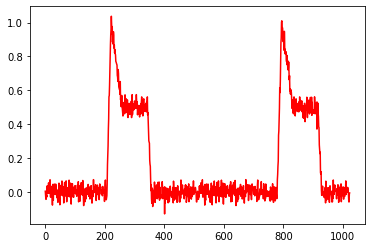

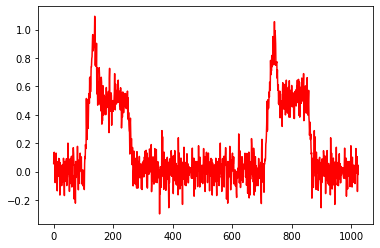

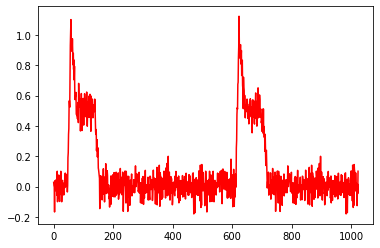

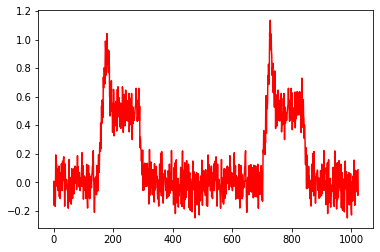

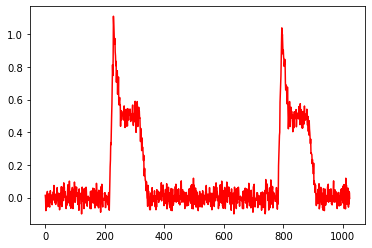

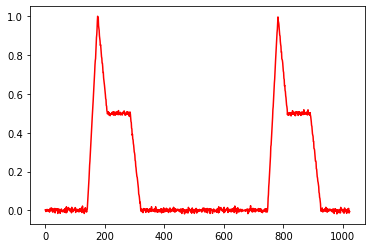

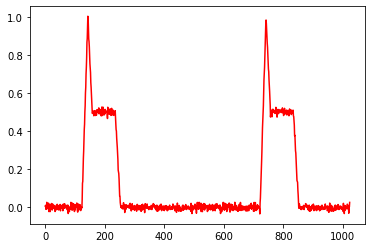

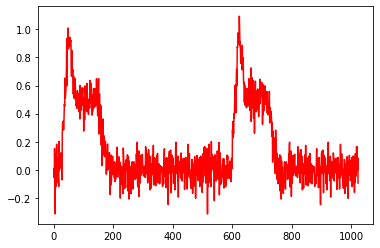

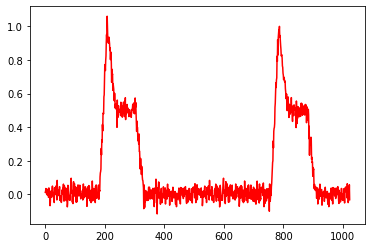

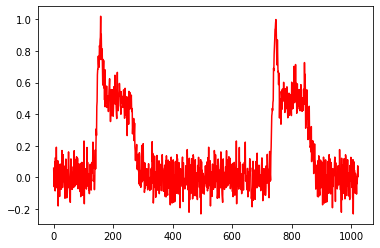

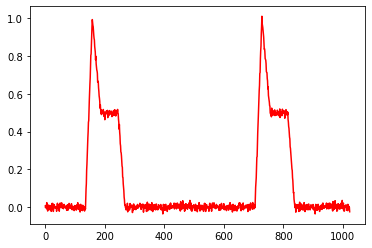

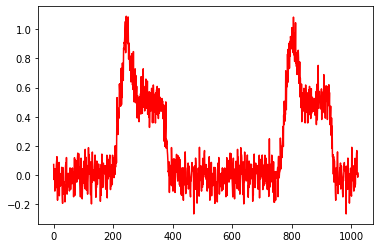

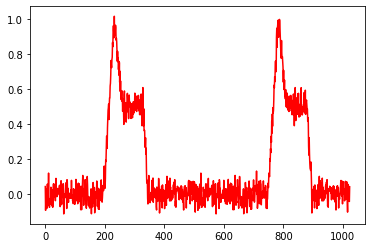

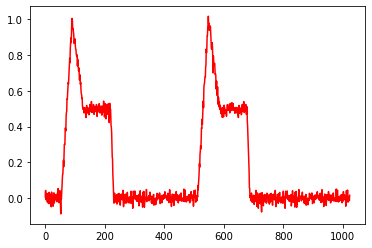

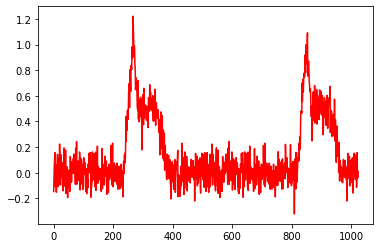

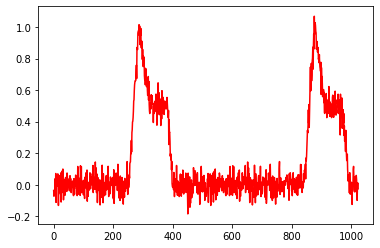

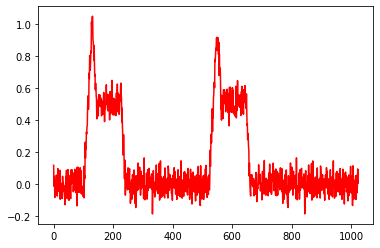

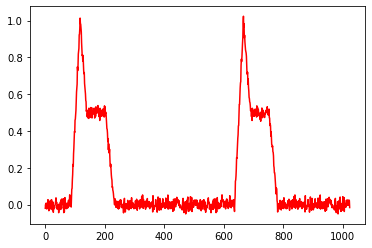

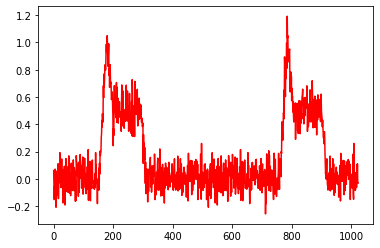

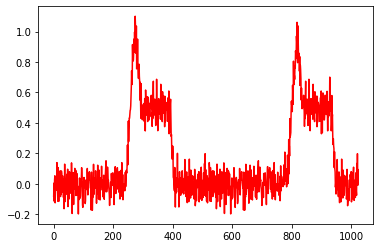

In [107]:
#main

filenames = laadarraymetfilenamenuitmap(train_set)
filenamesASDR = filenames[0:199]
filenamesGAUSS = filenames[200:399]
filenamesSBOX = filenames[400:599]
trainingdata = np.empty   #array met arrays van 1024 samples
delaypiek = []    #array met actuele delays tussen de pieken (validatiecijfers voor training)

for data in filenames:
  evencheck += 1
  if k != 0 and evencheck % 2 == 0:
    masterfile = voegsamen(previous, data)
    trainingdata = np.append(trainingdata, masterfile)
    nummer += 1
    if evencheck < 41:  #evencheck > aantal grafieken*2
      '''
      print(type(np.load(previous)))
      print("previous: " + previous)
      print(np.load(previous))
      print("data: " + data)
      print(np.load(data))
      '''
      print(masterfile) #MASTERFILE IS DE ARRAY VAN 1024 SAMPLES VAN DE TWEE SIGNALEN TEGARE
      
      plot= plt.figure(nummer)
      plt.plot(x,masterfile, color="red")

    delaypiek.append(512-int(geefpositiepiek(previous))+int(geefpositiepiek(data)))
      
  k += 1
  previous = data
#print(delaypiek)




In [108]:
print(trainingdata)

[<built-in function empty> 0.005852496310635956 -0.019864694697853034 ...
 0.05693974849863266 0.03928545124974021 -0.020003040051408898]


In [109]:
# Create a model
model = tf.keras.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(1,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))

In [110]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 16)                32        
                                                                 
 dense_26 (Dense)            (None, 16)                272       
                                                                 
 dense_27 (Dense)            (None, 16)                272       
                                                                 
 dense_28 (Dense)            (None, 16)                272       
                                                                 
 dense_29 (Dense)            (None, 1)                 17        
                                                                 
Total params: 865
Trainable params: 865
Non-trainable params: 0
_________________________________________________________________


In [111]:
# Add optimizer, loss function, and metrics to model and compile it
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

In [112]:
# Train model

history = model.fit(x,
                    masterfile,
                    epochs=5,
                    batch_size=64,)
                    

Epoch 1/5
16/16 [==============================] - 1s 2ms/step - loss: 2.9071 - mae: 2.9071
Epoch 2/5
16/16 [==============================] - 0s 2ms/step - loss: 0.6533 - mae: 0.6533
Epoch 3/5
16/16 [==============================] - 0s 2ms/step - loss: 0.4638 - mae: 0.4638
Epoch 4/5
16/16 [==============================] - 0s 2ms/step - loss: 0.4517 - mae: 0.4517
Epoch 5/5
16/16 [==============================] - 0s 2ms/step - loss: 0.5203 - mae: 0.5203


In [113]:
#%reset